<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB2] - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first classification of our traffic signs
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :** To be able to use this notebook and the following, **you must have generated the enhanced datasets** in <dataset_dir>/enhanced via the notebook **[01-Preparation-of-data.ipynb](01-Preparation-of-data.ipynb)**  

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

# Init Fidle environment
import fidle

run_id, run_dir, datasets_dir = fidle.init('GTSRB2')

2023-06-23 16:26:30.287378: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-23 16:26:30.497084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 16:26:31.121008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : GTSRB2
Run dir              : ./run/GTSRB2
Datasets dir         : /home/hcourtei/Projects/FormationSED/PreProcess_29Juin2023/fidle-tp/datasets-fidle
Start time           : 23/06/23 16:26:32
Hostname             : ptb-jkp7wl3.irisa.fr (Linux)
Tensorflow log level : Warning + Error  (=1)
Update keras cache   : False
Save figs            : ./run/GTSRB2/figs (False)
tensorflow           : 2.12.0
tensorflow.keras     : 2.12.0
numpy                : 1.23.5
sklearn              : 1.2.2
matplotlib           : 3.7.1
pandas               : 2.0.2


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.\
`fit_verbosity` is the verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

In [2]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 5
scale         = 0.1
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale', 'fit_verbosity')

## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    chrono=fidle.Chrono()
    chrono.start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=fidle.utils.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = chrono.get_delay()
    size     = fidle.utils.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = fidle.utils.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(1960, 24, 24, 1) (1960,)
Datasets have been shuffled.
Dataset "set-24x24-L" is loaded and shuffled. (12.0 Mo in 0:00:00)
Datasets have been resized with a factor  0.1


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (196, 24, 24, 1)
y_train :  (196,)
x_test  :  (63, 24, 24, 1)
y_test  :  (63,)


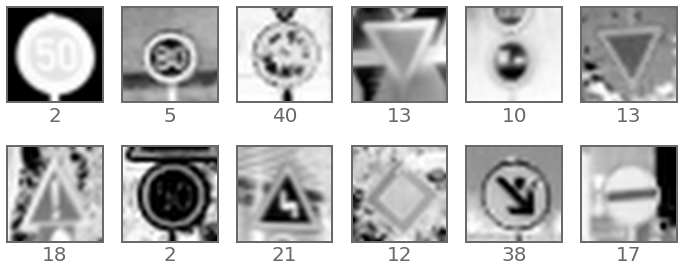

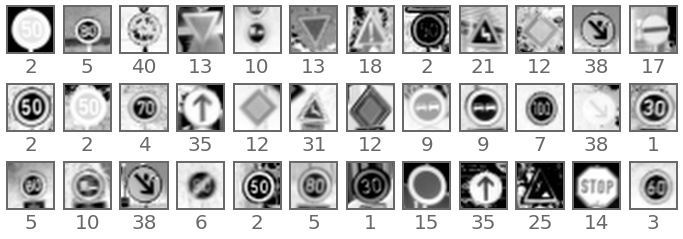

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

fidle.scrawler.images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
fidle.scrawler.images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [6]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

2023-06-23 16:27:11.429900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


**Train it :**

In [9]:
chrono=fidle.Chrono()
chrono.start()

# ---- Shuffle train data
x_train,y_train=fidle.utils.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

chrono.show()

Datasets have been shuffled.
Epoch 1/5
4/4 [==============================] - 1s 57ms/step - loss: 3.7014 - accuracy: 0.0510 - val_loss: 3.6111 - val_accuracy: 0.0952
Epoch 2/5
4/4 [==============================] - 0s 29ms/step - loss: 3.4950 - accuracy: 0.0612 - val_loss: 3.6094 - val_accuracy: 0.0317
Epoch 3/5
4/4 [==============================] - 0s 30ms/step - loss: 3.4802 - accuracy: 0.0306 - val_loss: 3.6251 - val_accuracy: 0.0317
Epoch 4/5
4/4 [==============================] - 0s 29ms/step - loss: 3.4484 - accuracy: 0.0510 - val_loss: 3.6007 - val_accuracy: 0.0317
Epoch 5/5
4/4 [==============================] - 0s 29ms/step - loss: 3.4378 - accuracy: 0.0408 - val_loss: 3.5903 - val_accuracy: 0.0317
Duration :  1.15 seconds


## Step 5 - Evaluate

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.0952


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 3.5903
Test accuracy  : 0.0317


In [12]:
fidle.end()

**End time :** 23/06/23 16:27:12  
**Duration :** 00:00:41 742ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>